In [2]:
import numpy as np
import time
import math
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

In [19]:
def oprod(T):
    out=T[0]
    for i in range(1,len(T)):
        out=np.multiply.outer(out,T[i])
    return out
def ID(N,d):
    out=np.zeros((N,)*d,dtype=int)
    for i in range(N):
        out[(i,)*A]=1
    return out

[['a' 'b' 'c']
 ['d' 'e' 'f']
 ['g' 'h' 'i']]
[{'a': 0, 'd': 1, 'g': 2}, {'b': 0, 'e': 1, 'h': 2}, {'c': 0, 'f': 1, 'i': 2}]


<IPython.core.display.Javascript object>


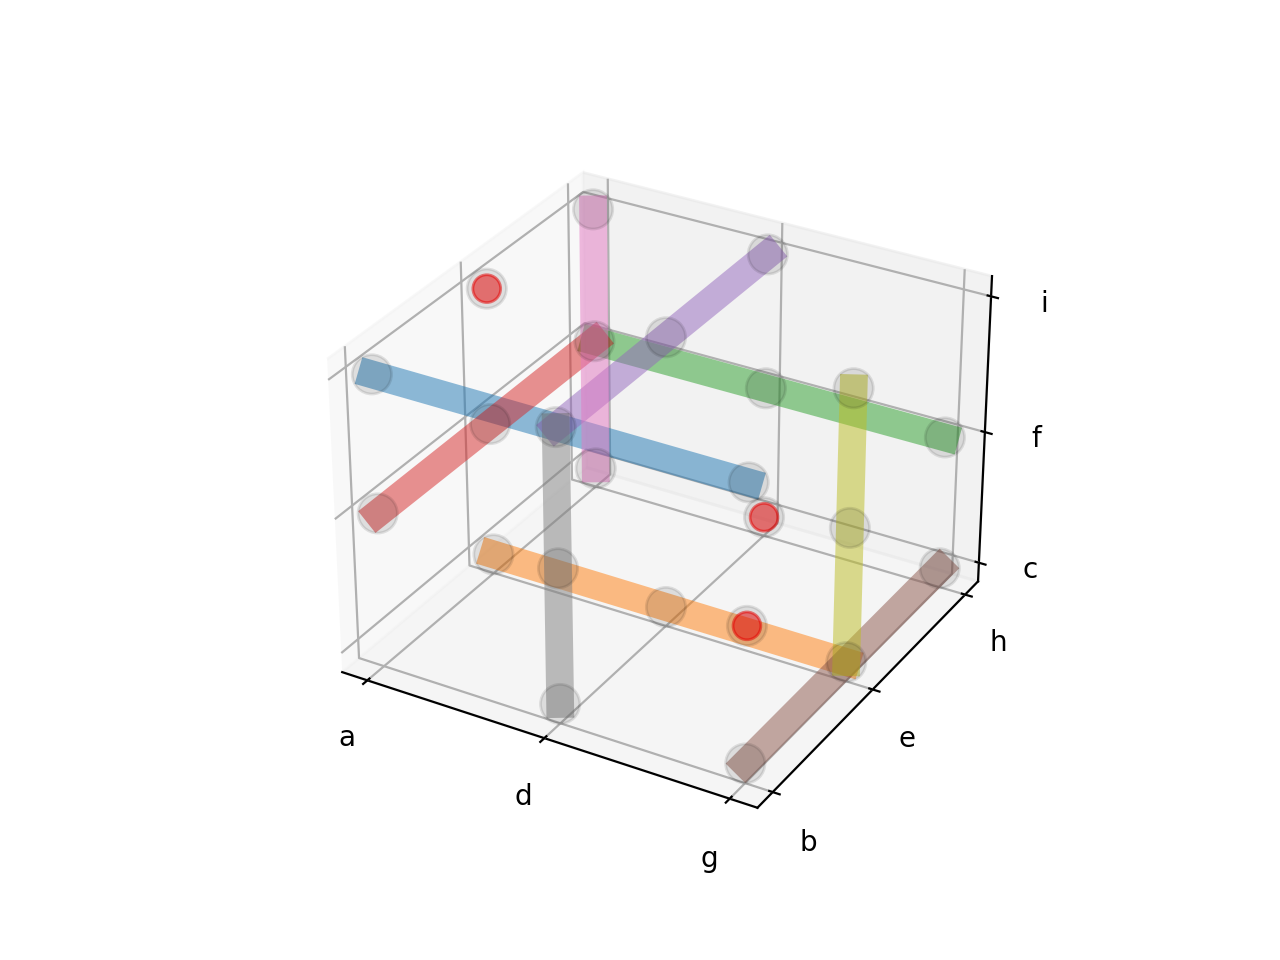

['bi', 'ec', 'hf', 'af', 'di', 'gc', 'ah', 'db', 'ge']
total # of unwanted terms=3
unwanted terms:
[0 1 2] aei
[1 2 0] dhc
[2 0 1] gbf


In [28]:
'''
based on the paper "On Practical Algorithms for Accelerated Matrix Multiplication" (Laderman, Pan, Sha)
'''
N,A=3,3
prods=np.array([chr(ord('a')+i) for i in range(N*A)]).reshape((N,A))#['abc','pqr','uvw','xyz']#['abc','uvw','xyz']#
print(prods)
groups=np.transpose(prods)
coords=list(map(lambda s:{s[i]:i for i in range(len(s))},groups))
print(coords)
def toltrs(s):
    axes=[list(g) for g in groups]
    for c in s:
        for ax in range(A):
            if c in groups[ax]:
                axes[ax]=[c]
                break
    return axes
def toaxes(ltrsets):
    out=[[]]*A
    for ax in range(A):
        out[ax]=[0]*N
        for ltr in ltrsets[ax]:
            out[ax][coords[ax][ltr]]=1
    return np.array(out)
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.set_xticks(range(N))
ax.set_yticks(range(N))
ax.set_zticks(range(N))
ax.set_xticklabels(groups[0])
ax.set_yticklabels(groups[1])
ax.set_zticklabels(groups[2])
target=oprod([[1]*N]*A)-ID(N,A)
ax.scatter(*np.where(target>0),c='black',s=200,alpha=0.1)
idxtype={prods[n][a]:(a+n)%A for n in range(N) for a in range(A)}
pcs=[]
for a in range(A):
    axes=list(groups[:])
    del axes[a]
    for v0 in axes[0]:
        for v1 in axes[1]:
            if idxtype[v0]==idxtype[v1]:
                pcs.append(v0+v1)
print(pcs)
ret=target
for pc in pcs:
    t=oprod(toaxes(toltrs(pc)))
    ret-=t
    ax.plot(*np.where(t),alpha=0.5,linewidth=10)
for i in range(N):
    assert ret[(i,)*A]==0, 'removed target term'
ret=np.maximum(ret,0)
ax.scatter(*np.where(ret>0),c='red',s=100,alpha=0.5)
print('total # of unwanted terms='+str(np.sum(ret)))
print('unwanted terms:')
for pt in np.transpose(np.where(ret>0)):
    print(str(pt)+' '+''.join([prods[pt[i]][i] for i in range(A)]))

In [53]:
def tot_terms(N,A,combos,idxtype=None):
    #find sets of coords of unwanted terms
    if idxtype==None:
        idxtype=np.array([[(r+c)%A for c in range(A)] for r in range(N)])
    print('idxtype='+str(idxtype))
    #0->ij, 1->jk, 2->ki
    idxgroup=[]
    for i in range(A):
        idxgroup.append((i,(i+1)%A))
    special_terms=[]
    for term in np.transpose(np.where(np.zeros((N,)*3)==0)):
        if len(set([idxtype[term[i]][i] for i in range(A)]))==A:
            special_terms.append(term)
    print('special_terms='+str(special_terms))

    def terms(S,R):
        S,R=map(lambda x:np.array(x).astype(int),(S,R))
        assert S.shape==(N,A) and R.shape==(N,A), 'incorrect shapes of S, R'
#         for r in range(N):
#             assert np.prod(S[r])==1, 'product(S['+str(r)+'])='+str(np.prod(S[r]))+'!=1'
        print('S='+str(S))
        print('R='+str(R))
        out={}
        for term in special_terms:
            coeff=1
            for i in range(A):
                coeff*=S[term[i]][i]
            idxsig=[]
            for i in range(A):
                group=[R[term[i]][j] for j in idxgroup[idxtype[term[i]][i]]]
                idxsig.append(tuple(group))
            out[(tuple(term),tuple(idxsig))]=coeff
        return out

    def add_terms(T0,T1):
        terms=set([*set(T0.keys()),*set(T1.keys())])
        out={}
        for t in terms:
            coeff=(T0[t] if t in T0 else 0)+(T1[t] if t in T1 else 0)
            if coeff!=0:
                out[t]=coeff
        return out

    tT={}
    for combo in combos:
        tT=add_terms(tT,terms(*combo))
    return tT

#Pan's solution for 3-way trilinear aggregation for 2x2 block matrices having nxn matrices as elements
coeffss=[]
for i in range(4):
    S=np.ones((N,A))
    if i>0:
        S[i-1][0]=S[i-1][2]=-1
    coeffss.append(S)
sigs=[np.zeros((N,A)),[[0,0,1],[0,1,0],[1,0,0]],[[0,1,0],[1,0,0],[0,0,1]],[[1,0,0],[0,0,1],[0,1,0]]]
# coeffss=list(map(lambda mat:[*mat,mat[0]],coeffss))
# sigs=list(map(lambda mat:[*mat,1-np.array(mat[0])],sigs))
# tT=tot_terms(4,3,[*[(coeffss[i],sigs[i]) for i in range(4)],*[(coeffss[i],1-np.array(sigs[i])) for i in range(4)]])

#4-way trilinear aggregation
#tT=tot_terms(4,3,[(np.ones((4,3)),np.zeros((4,3))),],[[0,1,2],[1,2,0],[2,0,1],[2,1,0]])
from itertools import permutations
def double(mat):
    out=[]
    for row in mat:
        for i in range(2):
            out.append(row)
    return out
coeffss=list(map(double,coeffss))
sigs=list(map(double,sigs))
tT=tot_terms(6,3,
             [*[(coeffss[i],sigs[i]) for i in range(4)],*[(coeffss[i],1-np.array(sigs[i])) for i in range(4)]],
             #[(np.ones((6,3)),np.zeros((6,3)))],
             list(permutations(range(3))))

keys=sorted(list(tT.keys()))
for k in keys:
    print(('!!!' if len(set(k[0]))>1 else '')+str(k).replace(' ','')+': '+str(tT[k]))
print('tot # keys='+str(len(tT)))

idxtype=[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
special_terms=[array([0, 0, 0]), array([0, 0, 2]), array([0, 1, 1]), array([0, 1, 4]), array([0, 3, 1]), array([0, 3, 4]), array([0, 5, 0]), array([0, 5, 2]), array([1, 0, 0]), array([1, 0, 2]), array([1, 1, 1]), array([1, 1, 4]), array([1, 3, 1]), array([1, 3, 4]), array([1, 5, 0]), array([1, 5, 2]), array([2, 1, 3]), array([2, 1, 5]), array([2, 2, 0]), array([2, 2, 2]), array([2, 3, 3]), array([2, 3, 5]), array([2, 4, 0]), array([2, 4, 2]), array([3, 1, 3]), array([3, 1, 5]), array([3, 2, 0]), array([3, 2, 2]), array([3, 3, 3]), array([3, 3, 5]), array([3, 4, 0]), array([3, 4, 2]), array([4, 0, 3]), array([4, 0, 5]), array([4, 2, 1]), array([4, 2, 4]), array([4, 4, 1]), array([4, 4, 4]), array([4, 5, 3]), array([4, 5, 5]), array([5, 0, 3]), array([5, 0, 5]), array([5, 2, 1]), array([5, 2, 4]), array([5, 4, 1]), array([5, 4, 4]), array([5, 5, 3]), array([5, 5, 5])]
S=[[1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]

<IPython.core.display.Javascript object>


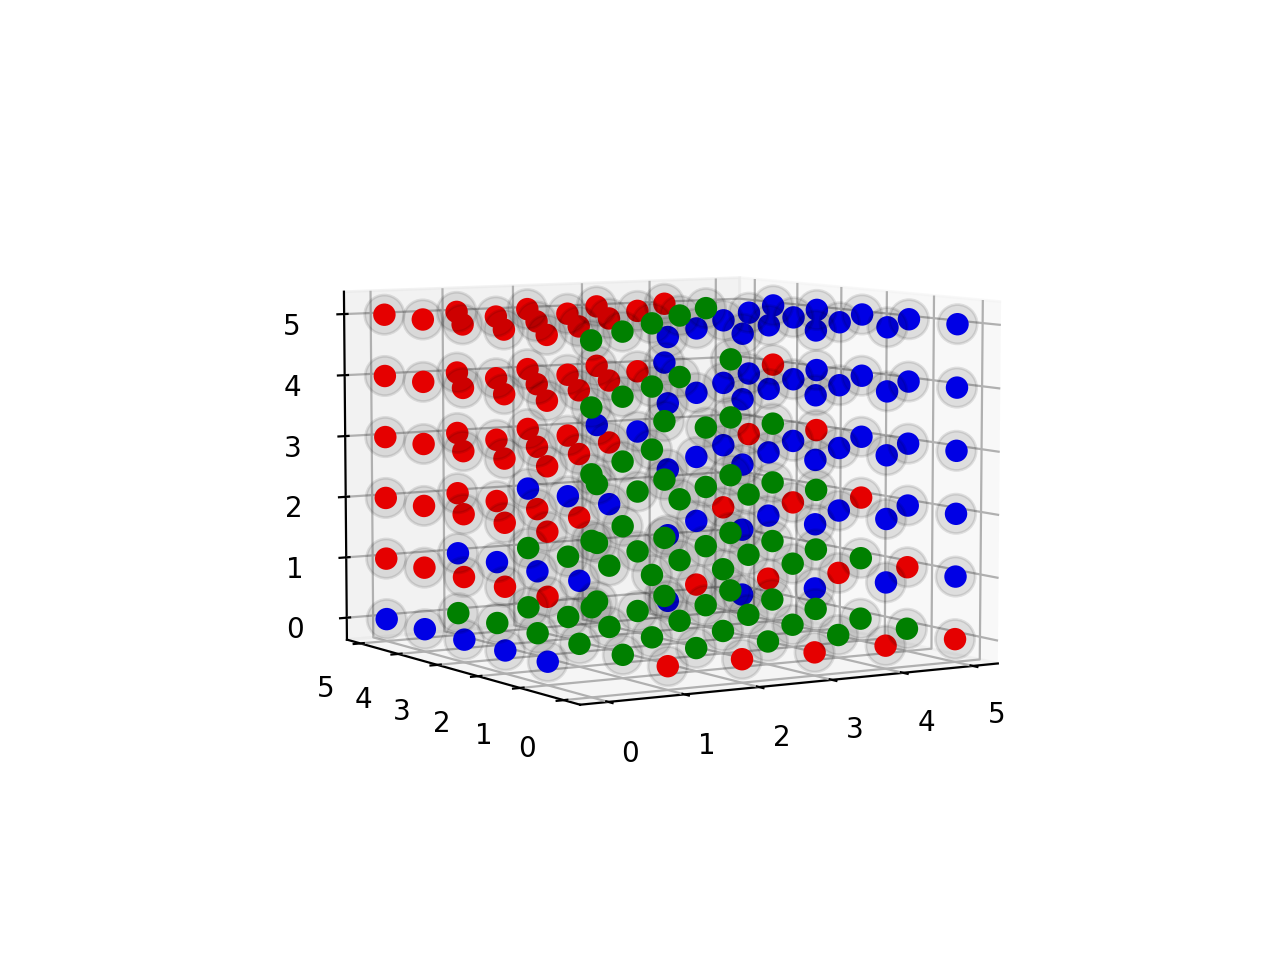

total err=0


In [86]:
N=6
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.set_xticks(range(N))
ax.set_yticks(range(N))
ax.set_zticks(range(N))
target=np.array([[[(1 if len(set([i,j,k]))>1 else 0) for k in range(N)] for j in range(N)] for i in range(N)])
generator=np.array([[[(1 if (i<j and i<k and j!=k) or (j==k and i!=j) else 0) for k in range(N)] for j in range(N)] for i in range(N)])
ax.scatter(*np.where(target>0),c='black',s=200,alpha=0.1)
ax.scatter(*np.where(generator>0),c='red',s=50,alpha=1)
ax.scatter(*np.where(np.transpose(generator,[1,2,0])>0),c='green',s=50,alpha=1)
ax.scatter(*np.where(np.transpose(generator,[2,0,1])>0),c='blue',s=50,alpha=1)
ret=generator+np.transpose(generator,[1,2,0])+np.transpose(generator,[2,0,1])
print('total err='+str(np.sum((ret-target)**2)))

In [145]:
def mmT(N):
    T=np.zeros((N,)*6,dtype=int)
    for i in range(N):
        for j in range(N):
            for k in range(N):
                T[i][j][j][k][k][i]=1
    return T
def oprod(T):
    out=T[0]
    for i in range(1,len(T)):
        out=np.multiply.outer(out,T[i])
    return out
def compress(T):
    S=T.shape
    assert len(S)%2==0, 'odd-dimensional tensor'
    nS=[]
    for i in range(0,len(S),2):
        nS.append(S[i]*S[i+1])
    return T.reshape(tuple(nS))
def sumdecomp(decomp):
    return sum(map(oprod,decomp))
def plotT(ax,T,colmap=(lambda x:plt.get_cmap('bwr')(128*x+128)),s=100,**kwargs):
    data=np.array(np.where(T!=0))
    ax.scatter(*data,c=list(map(lambda pt:colmap(T[tuple(pt)]),np.transpose(data))),**kwargs)

<IPython.core.display.Javascript object>


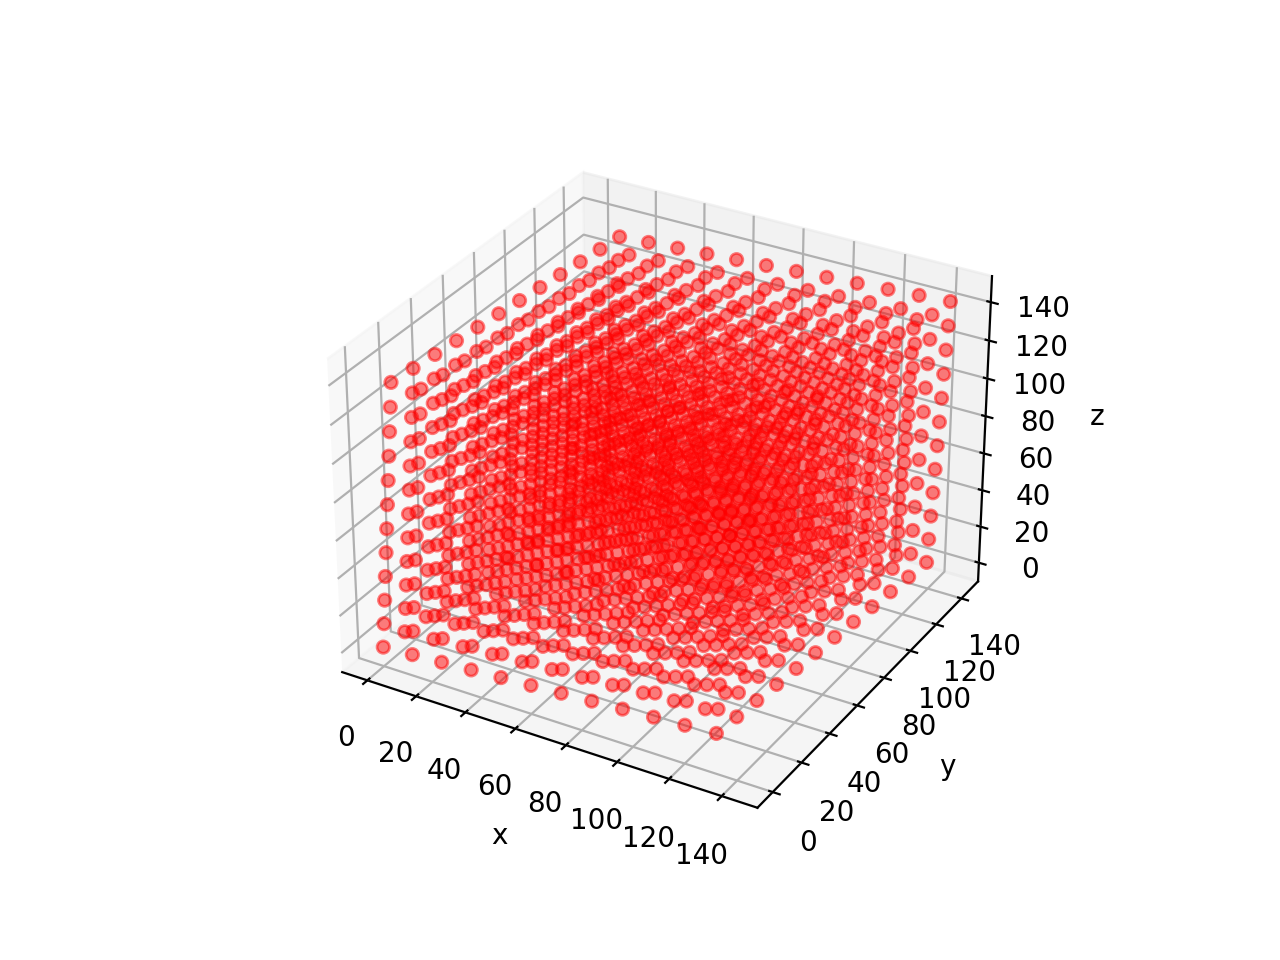

[70, 30, 26, 30]
[(array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])), (array([[-1.,  1., -1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]]), [[0, 0, 1], [0, 1, 0], [1, 0, 0]]), (array([[ 1.,  1.,  1.],
       [-1.,  1., -1.],
       [ 1.,  1.,  1.]]), [[0, 1, 0], [1, 0, 0], [0, 0, 1]]), (array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [-1.,  1., -1.]]), [[1, 0, 0], [0, 0, 1], [0, 1, 0]]), (array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])), (array([[-1.,  1., -1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]]), array([[1, 1, 0],
       [1, 0, 1],
       [0, 1, 1]])), (array([[ 1.,  1.,  1.],
       [-1.,  1., -1.],
       [ 1.,  1.,  1.]]), array([[1, 0, 1],
       [0, 1, 1],
       [1, 1, 0]])), (array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [-1.,  1., -1.]]), array([[0, 1, 1],
       [1, 1, 0],
       [1,

In [173]:
#demonstration of (a simplified version of) Pan's trilinear aggregation technique on a single matrix multiplication
#2n by 2n matrix multiplication is doable in 8*((n^3-n)/3+6n(n-1)+3((n-1)^2+1)+n) element-element multiplications
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
N=6
TARGET=mmT(2*N)
E=lambda i,j:np.array([[1 if r==i and c==j else 0 for c in range(2*N)] for r in range(2*N)])
#plotT(ax,compress(TARGET),s=400,alpha=0.1)
S=set()
for i in range(N):
    for j in range(N):
        for k in range(N):
            if (i<j and i<k and j!=k) or (j==k and i!=j):
                S.add((i,j,k))
Sij,Sjk,Ski=set([(i,j) for i,j,k in S]),set([(j,k) for i,j,k in S]),set([(k,i) for i,j,k in S])
print(list(map(len,(S,Sij,Sjk,Ski))))
def Pan_decomp(C,I):
    X=lambda s,t,r,c:C[s][t]*E(r+I[s][(s+t)%3]*N,c+I[s][(s+t+1)%3]*N)
    return [
        *[(X(0,0,i,j)+X(1,0,j,k)+X(2,0,k,i),X(0,1,j,k)+X(1,1,k,i)+X(2,1,i,j),X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k)) for i,j,k in S],

        *[(-X(0,0,i,j),X(2,1,i,j),sum([(X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k)) if (i,j,k) in S else 0 for k in range(N)])) for i,j in Sij],
        *[(-X(0,0,i,j),sum([(X(0,1,j,k)+X(1,1,k,i)) if (i,j,k) in S else 0 for k in range(N)]),X(1,2,i,j)) for i,j in Sij],
        *[(-sum([(X(1,0,j,k)+X(2,0,k,i)) if (i,j,k) in S else 0 for k in range(N)]),X(2,1,i,j),X(1,2,i,j)) for i,j in Sij],

        *[(-X(1,0,j,k),X(0,1,j,k),sum([(X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k)) if (i,j,k) in S else 0 for i in range(N)])) for j,k in Sjk],
        *[(-X(1,0,j,k),sum([(X(1,1,k,i)+X(2,1,i,j)) if (i,j,k) in S else 0 for i in range(N)]),X(2,2,j,k)) for j,k in Sjk],
        *[(-sum([(X(0,0,i,j)+X(2,0,k,i)) if (i,j,k) in S else 0 for i in range(N)]),X(0,1,j,k),X(2,2,j,k)) for j,k in Sjk],

        *[(-X(2,0,k,i),X(1,1,k,i),sum([(X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k)) if (i,j,k) in S else 0 for j in range(N)])) for k,i in Ski],
        *[(-X(2,0,k,i),sum([(X(0,1,j,k)+X(2,1,i,j)) if (i,j,k) in S else 0 for j in range(N)]),X(0,2,k,i)) for k,i in Ski],
        *[(-sum([(X(0,0,i,j)+X(1,0,j,k)) if (i,j,k) in S else 0 for j in range(N)]),X(1,1,k,i),X(0,2,k,i)) for k,i in Ski],
    ]
coeffss=[]
for i in range(4):
    tmp=np.ones((3,3))
    if i>0:
        tmp[i-1][0]=tmp[i-1][2]=-1
    coeffss.append(tmp)
sigs=[np.zeros((3,3)),[[0,0,1],[0,1,0],[1,0,0]],[[0,1,0],[1,0,0],[0,0,1]],[[1,0,0],[0,0,1],[0,1,0]]]
tables=list(zip(coeffss,sigs))
tables.extend(list(zip(coeffss,list(map(lambda x:1-np.array(x),sigs)))))
print(tables)
decomp=[(E(i+a*N,i+b*N),E(i+b*N,i+c*N),E(i+c*N,i+a*N)) for i in range(N) for a in range(2) for b in range(2) for c in range(2)]
for t in range(8):
    decomp.extend(Pan_decomp(*tables[t]))
plotT(ax,compress(sumdecomp(decomp)),alpha=0.5)
print('err='+str(np.sum(mmT(2*N)-sumdecomp(decomp))))
print('# multiplications='+str(len(decomp)))